<h3> Imports

In [42]:
import sys
sys.path.append("../src")
from precomputed_dataset import precomputedDataset
from modules import MPNNLayer, MPNNTokenizer, SelfAttentionEncoder, PredictionHead
from model import MPNNTransformerModel

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader as PyGDataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

<h3> Helper Functions

In [43]:
def check_gradients(model):
    """Check if gradients are flowing properly"""
    total_norm = 0.0
    param_count = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
            param_count += 1
    total_norm = total_norm ** 0.5
    return total_norm, param_count

<h3> Dataset and Device Setup

In [44]:
# Deterministic behavior for reproducibility
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device setup
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset setup
h5_path = "../data/b_train_10k.h5"
ds = precomputedDataset(h5_path)

# DataLoader - use PyG's DataLoader for graph data
# Smaller batch for overfitting test to see per-sample behavior
batch_size = 32
loader = PyGDataLoader(
    ds, 
    batch_size=batch_size, 
    shuffle=True,  # Shuffle even for overfitting to avoid order effects
    num_workers=4,  # 0 for debugging, increase later
    pin_memory=True if torch.cuda.is_available() else False
)

Using device: cuda:2


<h3> Model

In [45]:
def restart_model():
    sample0 = ds[0]
    node_in_dim = sample0.x.shape[-1]
    edge_in_dim = sample0.edge_attr.shape[-1]

    model = MPNNTransformerModel(
        node_in_dim=node_in_dim,
        edge_in_dim=edge_in_dim,
        #
        num_output_sources=1,  
        #
        mpnn_hidden_dim=128,
        mpnn_num_layers=2,  # Start with 2, you mentioned removing residuals helped
        mp_layer_norm=False,  # Disable layer norm for overfitting test
        #
        token_dim=128,
        attn_num_heads=4,
        attn_num_layers=4,  # Reduced from 12 for faster overfitting
        #
        head_mlp_hidden_dim=256,  # Smaller for faster overfitting
        #
        mpnn_dropout=0.1,   # No dropout for overfitting test
        attn_dropout=0.1,   # No dropout for overfitting test
        head_dropout=0.1,   # No dropout for overfitting test
        #
        pooling_strategy="cls_token" # "mean_pooling" or "cls_token"
    ).to(device)

    return model


<h3> Optimizer and Loss

In [ ]:
model = restart_model()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.0, #weight decay lead to slower convergence but no improvement in test loss, so removed for now
    betas=(0.9, 0.999),
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,          
    patience=10, #used to be 25       
    threshold=1e-5, #used to be 5e-5    
    threshold_mode="rel",
    cooldown=5, #used to be 10        
    min_lr=1e-7, #used to be 1e-6
)


<h3> Training Loop

In [ ]:
# Number of epochs 
num_epochs = 1000

# Tracking metrics
loss_history = []
pred_std_history = []
grad_norm_history = []

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    epoch_preds = []
    
    for batch_idx, data in enumerate(loader):
        data = data.to(device)
        
        # Forward pass
        pred = model.forward_from_data(data)  
        target = data.y  

        assert pred.shape == target.shape
            
        # Loss
        loss = F.mse_loss(pred, target)
        
        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        
        # --- Gradient clipping, see if this helps with stability ---
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_preds.append(pred.detach().cpu().numpy())
        
    # Epoch statistics
    avg_loss = epoch_loss / len(loader)
    #For now no scheduler
    #scheduler.step(avg_loss)
    loss_history.append(avg_loss)
    
    # Check gradient flow
    grad_norm, _ = check_gradients(model)
    grad_norm_history.append(grad_norm)
    
    # Prediction diversity (critical for detecting collapse)
    all_preds = np.concatenate(epoch_preds, axis=0)
    pred_std = all_preds.std(axis=0).mean()
    pred_std_history.append(pred_std)
    
    # Logging
    if epoch == 1 or epoch % 1 == 0:
        print(f"Epoch {epoch:4d} | Loss: {avg_loss:.6f} | "
                f"Pred_std: {pred_std:.4f} | Grad_norm: {grad_norm:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Check for collapse to fixed prediction
        if pred_std < 0.001:
            print(f"  WARNING: Predictions collapsed to near-constant value!")
            print(f"  Mean prediction: {all_preds.mean(axis=0)}")
            break
            
    # Early stopping
    if avg_loss < 5e-5:
        print(f"\n Converged at epoch {epoch} with loss {avg_loss:.8f}")
        break


STARTING TRAINING


KeyboardInterrupt: 

<h1> Final Evaluation

In [ ]:
print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

test_path = "../data/b_test_1k.h5"
test_ds = precomputedDataset(test_path)

model.eval()
predictions = []
targets = []
sample_losses = []

with torch.no_grad():
    for i in range(len(test_ds)):
        data = test_ds[i].to(device)
        pred = model.forward_from_data(data)
        target = data.y
        target.squeeze_(0)  
      
        # Compute loss for this sample
        loss = F.mse_loss(pred, target)
        sample_losses.append(loss.item())
        
        # Store predictions and targets
        pred_np = pred.cpu().numpy().squeeze()
        target_np = target.cpu().numpy().squeeze()
        
        predictions.append(pred_np)
        targets.append(target_np)

# Convert to arrays
predictions = np.array(predictions)  # [N, 2]
targets = np.array(targets)          # [N, 2]
sample_losses = np.array(sample_losses)

# Compute average test loss (mean over all samples)
avg_test_loss = sample_losses.mean()

# Print comparison with training
print(f"\nLoss Comparison:")
print(f"  Final train loss: {loss_history[-1]:.6f}")
print(f"  Test loss:        {avg_test_loss:.6f}")
print(f"  Generalization gap: {avg_test_loss - loss_history[-1]:.6f}")

print("="*60 + "\n")


FINAL EVALUATION

Loss Comparison:
  Final train loss: 0.003365
  Test loss:        0.004826
  Generalization gap: 0.001461



<h2> Metrics I need to take a look at


Error Metrics:
  Mean L2 error:   0.060715
  Median L2 error: 0.031534
  Std L2 error:    0.080149
  Max L2 error:    0.572790
  MAE X:           0.038984
  MAE Y:           0.038419

Accuracy Bands:
  < 0.1m: 83.9%
  < 0.5m: 99.7%
  < 1.0m: 100.0%

Prediction Statistics:
  Pred mean: [0.0070, -0.0045]
  Pred std:  [0.1600, 0.1547]
  Target mean: [0.0087, -0.0023]
  Target std:  [0.1668, 0.1621]

Sample Predictions (first 10):
Idx  Pred_X    Pred_Y    Target_X  Target_Y  Error   
------------------------------------------------------------
0      0.1247    0.1165    0.0638    0.2753   0.1701
1      0.0468   -0.0748    0.0315   -0.0691   0.0163
2      0.2232   -0.2446    0.2613   -0.2415   0.0382
3     -0.2053    0.3684   -0.2693    0.3367   0.0714
4      0.2778   -0.1088    0.2981   -0.0855   0.0309
5      0.1123    0.0049    0.1058   -0.0171   0.0230
6     -0.0641   -0.0058    0.1700   -0.1487   0.2743
7      0.1691   -0.0496    0.1619   -0.1905   0.1411
8     -0.1317    0.0187   -0.

ValueError: Unknown format code 'd' for object of type 'str'

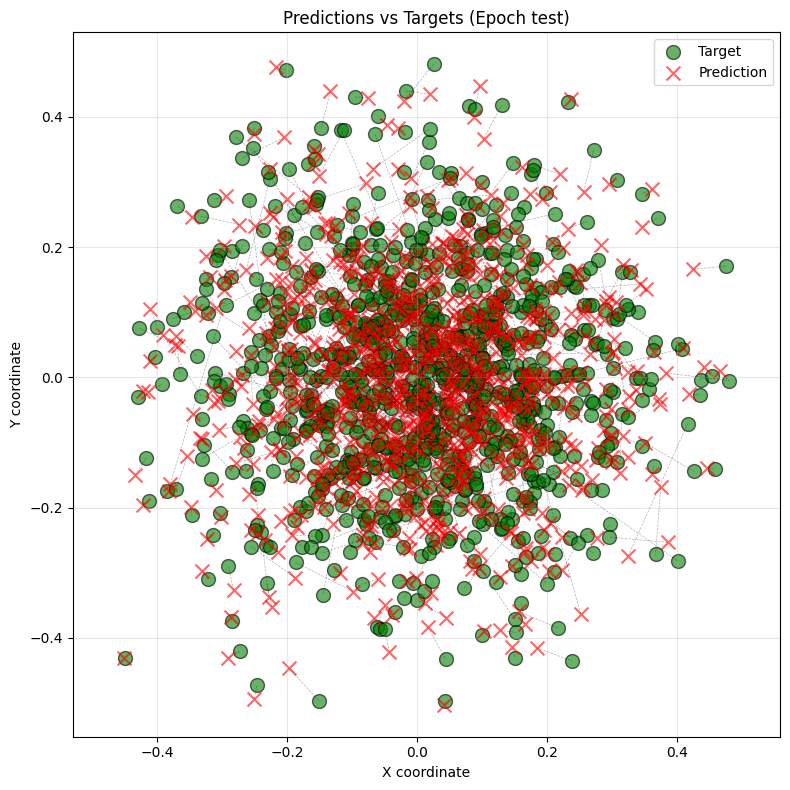

In [ ]:
# Compute error metrics
errors = np.linalg.norm(predictions - targets, axis=1)
mae_x = np.abs(predictions[:, 0] - targets[:, 0]).mean()
mae_y = np.abs(predictions[:, 1] - targets[:, 1]).mean()

print(f"\nError Metrics:")
print(f"  Mean L2 error:   {errors.mean():.6f}")
print(f"  Median L2 error: {np.median(errors):.6f}")
print(f"  Std L2 error:    {errors.std():.6f}")
print(f"  Max L2 error:    {errors.max():.6f}")
print(f"  MAE X:           {mae_x:.6f}")
print(f"  MAE Y:           {mae_y:.6f}")

# Accuracy bands (assuming coordinates in meters)
acc_01m = (errors < 0.1).mean() * 100
acc_05m = (errors < 0.5).mean() * 100
acc_10m = (errors < 1.0).mean() * 100

print(f"\nAccuracy Bands:")
print(f"  < 0.1m: {acc_01m:.1f}%")
print(f"  < 0.5m: {acc_05m:.1f}%")
print(f"  < 1.0m: {acc_10m:.1f}%")

# Prediction distribution
print(f"\nPrediction Statistics:")
print(f"  Pred mean: [{predictions[:, 0].mean():.4f}, {predictions[:, 1].mean():.4f}]")
print(f"  Pred std:  [{predictions[:, 0].std():.4f}, {predictions[:, 1].std():.4f}]")
print(f"  Target mean: [{targets[:, 0].mean():.4f}, {targets[:, 1].mean():.4f}]")
print(f"  Target std:  [{targets[:, 0].std():.4f}, {targets[:, 1].std():.4f}]")

# Sample predictions
print(f"\nSample Predictions (first 10):")
print(f"{'Idx':<4} {'Pred_X':<9} {'Pred_Y':<9} {'Target_X':<9} {'Target_Y':<9} {'Error':<8}")
print("-" * 60)
for i in range(min(10, len(predictions))):
    print(f"{i:<4} {predictions[i,0]:8.4f}  {predictions[i,1]:8.4f}  "
          f"{targets[i,0]:8.4f}  {targets[i,1]:8.4f}  {errors[i]:7.4f}")

def plot_predictions(predictions, targets, epoch, save_dir="plots"):
    """Visualize predictions vs targets"""
    Path(save_dir).mkdir(exist_ok=True)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(targets[:, 0], targets[:, 1], c='green', marker='o', 
                s=100, alpha=0.6, label='Target', edgecolors='black')
    plt.scatter(predictions[:, 0], predictions[:, 1], c='red', marker='x', 
                s=100, alpha=0.6, label='Prediction')
    
    # Draw lines connecting predictions to targets
    for i in range(len(predictions)):
        plt.plot([predictions[i, 0], targets[i, 0]], 
                [predictions[i, 1], targets[i, 1]], 
                'k--', alpha=0.3, linewidth=0.5)
    
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title(f'Predictions vs Targets (Epoch {epoch})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/predictions_epoch_{epoch:04d}.png", dpi=100)
    plt.close()

# Plot predictions vs targets
plot_predictions(predictions, targets, epoch="test", save_dir="plots")
